# EIP-1559: A transaction fee market proposal

###### March 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

EIP-1559 is perhaps one of the most anticipated upgrades to the economic model of Ethereum. Proposed by Vitalik Buterin in his [Pricing Blockchain Resources](https://github.com/ethereum/research/blob/master/papers/pricing/ethpricing.pdf) paper, the mechanism seeks to replace the first-price auction model governing the current fee market for transaction inclusion.

## Why EIP-1559?

### Transactions 101

Users submit _transactions_ to interact with a blockchain. In Ethereum, these transactions can be as simple as sending ether from one account to another, or as complex as making a contract perform something on your behalf (entering a lottery, executing a trade etc). In the latter case, your transaction might trigger other transactions to execute, cascading until no more side-effects take place. It is clear that the simple transfer is much less computation than a complex, multistage transaction, so we measure how much resources each transaction requires by how much _gas_ the transaction (and its potential cascading transactions) needs to execute.

The Ethereum Virtual Machine (EVM), which processes these transactions, has a cost in gas for each elementary operation: adding numbers, storing a value, transfering ether. All transactions are made up of an arbitrary number of these elementary operations (even the really complex ones!) Together, these elementary operations tally up to the gas necessary to process the entire transaction.

|| Transaction operations | Gas |
|-|-|-|
|1| Add | 20 |
|2| Transfer | 100 |
||**Transaction total** | 120 |

But space is few, as blocks are produced on a regular interval and offer only a limited amount of available gas. To avoid congestion, transaction senders ("users") price the gas they seek to use, e.g., specifying that they are ready to pay 6 Gwei per unit of gas to have their transaction included.

| Transaction gas | Gas price (Gwei) | Total fee (Gwei) |
|-|-|-|
| 120 | 6 | 720 |

### Auctions as market mechanism

In the current auction model, block producers typically select a set of the highest paying transactions, making sure that the total gas required by all transactions in the set does not exceed the limit amount of gas offered in a block. Users with selected transactions end up paying the gas price they specified, times the amount of gas their transaction required to be processed. Thus, users "pay what they bid": this is a first-price auction.

In the following table, we assume the block gas limit is 1,000. Though there is a transaction (the last one) paying out 700 Gwei, the block producer cannot include it as it would break the gas limit and thus prefers to include the first, 720 Gwei-valued, transactions. Users pay exactly the fee stated in the column.

| Transaction gas | Gas price (Gwei) | Total fee (Gwei) | Included? | Cumulative gas |
|-|-|-|-|-|
| 120 | 6 | 720 | Yes | 120 |
| 200 | 5 | 1000 | Yes | 320 |
| 700 | 1 | 700 | No | 320 |

The first-price auction has many defects. In its simplest theoretical model, where users bid simultaneously and privately, it is a well-known result that first-price auction are not incentive-compatible, meaning that users do not have the incentive to bid their true value for the transaction being included. Second-price auctions are though, when the winner of the auction pays the bid offered by the second-highest bidder.

So second-price auctions were considered as an alternative, but where we may hold Sotheby's accountable for manipulating the result of an auction, we can't quite always do that in the blockchain setting. Since block producers have the final say on who gets included or not, they can "stuff" the blocks with phony transactions from themselves to pump up the "second price", and thus trick the protocol into giving them more than what the market should offer while leaving honest fee-paying transactions by the curb ([this can be somewhat mitigated](https://arxiv.org/abs/1901.06830)).

### Pricing congestion and EIP-1559

Enters EIP-1559, written up in an [Ethereum improvement protocol (EIP) suggestion by Eric Conoar of EthHub fame and Buterin himself](https://eips.ethereum.org/EIPS/eip-1559). The proposal involves setting a variable _basefee_ to be paid by anyone who wishes to have a transaction included, with the base fee varying according to how empty or how full blocks are. The block limit is set to a fairly high value, while the EIP-1559 mechanism targets a fixed block size ([the amount of gas spent by transactions in the block](https://ethgasstation.info/blog/ethereum-block-size/)),

In dire times, when everyone is trying to upgrade their CryptoKitty or frantically closing out their debt positions, block sizes increase as more users are willing to pay the current basefee. In this case, the mechanism increases the basefee to price out users who just don't want it bad enough and return block sizes to its fixed target. Alternatively, when the chain is an open empty road to nowhere, we would prefer to encourage users to send their transactions in for cheap, so basefee should be much lower.

Under the auction market though, if a lot of people want to transact on the chain at the same time, the threshold bids making it into the blocks should steadily increase (and indeed, have done so in the past). Isn't that the same outcome as EIP-1559? Complicating things, we'll also see in our simulations that users can specify a "tip" paid out to the block producers, in addition to the basefee. A higher tip gets you to the end of the line faster, kind of like the auction mechanism does already. So why do we care about a mechanism seemingly not so different from the auction?

| Basefee (burned) | Tip (paid to block producer) | Total fee |
|-|-|-|
| 4 | 1 | 5 |

One clue is predictability. First-price auctions are notoriously hard to analyse even in the best of cases. It gets worse when bids are open (as they are to anyone who listens to the _mempool_ where user transactions languish before being included) and replaceable (as they are, though not so trivially, with transaction-replacement operations). There is hope that a more "algorithmic" price discovery mechanism will help remove this variability, even when demand fluctuates swiftly (we'll see some of that in the simulations below).

Another clue is analytic simplicity. Pricing things, and especially congestion, in the most parsimonious manner is one object of algorithmic game theory, which is the study of mechanisms from the computational lens. We know from Pigou, Vickrey and a long line of economists that we usually like to _internalise externalities_, i.e., make people pay for not only what they are doing _for_ themselves, but also what they are doing _to_ others.

When I am on the road in the morning, I impose my presence to everyone else also on the road, and vice-versa. This is why the most fundamental result in this corner of the discipline states that the correct price to pay for people cramming in some resource is exactly the _marginal price_: the price of the extra inconvenience for everyone else that your presence imposes. With first-price auctions, it is not clear that we ever get to that price. But a mechanism seeking to achieve some target (e.g., the amount of gas used by a block) and raising/lowering the price (e.g., the basefee) to meet that target gets much closer to this marginal price. And if that is simpler for us to analyse, that also means we get to predict a bit better how the mechanism will behave. Double whammy!

But ok, after this long intro, let's dive into the mechanics of the... ahem... mechanism. We'll first set up a simple cadCAD environment and progressively add on to it to simulate more and more complex phenomena.

## The environment

First, we define a simple `Transaction` class, as these are the base element of our simulation. Users produce transactions, which are sent to block producers who must select which of these transactions to include.

In [1]:
class Transaction:
    def __init__(self, gas_premium, fee_cap, gas_used):
        self.gas_premium = gas_premium
        self.fee_cap = fee_cap
        self.gas_used = gas_used

Second, we'll grab a few constants from the EIP, possibly looking to change them later on.

In [2]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 10000000,
    "MAX_GAS_EIP1559": 16000000,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10,
    "INITIAL_BASEFEE": 1000000000,
    "PER_TX_GASLIMIT": 8000000
}

Remember that we set up our cadCAD simulations as a repeating pattern of state updates and policies. For this simulation, here is our plan:

1. **(State update)** `update_demand`: Users generate some demand, a list of transactions added to the mempool.
2. **(Policy)** `include_all_txs`: We have more space to define what our policies are. For now, our block producers will include all transactions in the mempool inside their blocks (we'll make sure that the total amount of gas required won't exceed the gas limit in blocks).
3. **(State update)** `update_basefee`: Given the included transaction, the protocol checks whether the basefee needs to be updated or not. We'll go deeper into how this update works later on, for now, simply keep in mind that the fee should decrease as our blocks won't be full.

In [3]:
def update_demand(params, step, sL, s, _input):
    basefee = s["basefee"]
    demand = [Transaction(
        gas_premium = 1000000000,
        gas_used = 21000,
        fee_cap = 6000000000
    ) for i in range(100)]
    return ("demand", demand)
    
def include_all_txs(params, step, sL, s):
    demand = s["demand"]
    basefee = s["basefee"]
    miner_gains = 0
    tx_sender_fee = []
    total_gas_used = 0
    
    for tx in demand:
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        fee = gas_price * tx.gas_used
        tx_sender_fee += [fee]
        miner_gains += (gas_price - basefee) * tx.gas_used
        total_gas_used += tx.gas_used
        
    assert miner_gains >= 0
    return ({ "gas_used": total_gas_used })
    
def update_basefee(params, step, sL, s, _input):
    gas_used = _input["gas_used"]
    delta = gas_used - constants["TARGET_GAS_USED"]
    basefee = s["basefee"]
    new_basefee = basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    return ("basefee", new_basefee)

psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand # step 1
    }
}, {
    "policies": {
        "action": include_all_txs # step 2
    },
    "variables": {
        "basefee": update_basefee # step 3
    }
}]

We set our initial conditions: an empty demand and basefee starting from the EIP-defined constant `INITIAL_BASEFEE`.

In [4]:
initial_conditions = {
    "basefee": constants["INITIAL_BASEFEE"],
    "demand": []
}

Set up our simulation parameters: for now we will run the simulation for 300 steps (i.e., 300 blocks).

In [5]:
simulation_parameters = {
    'T': range(300),
    'N': 1,
    'M': {}
}

And finally set up and execute the simulation!

In [6]:
%%capture

from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

config = Configuration(initial_state=initial_conditions,
                       partial_state_update_blocks=psub,
                       sim_config=simulation_parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

OK! Our results are in `df`, so let's plot the `basefee` and see how that evolved.

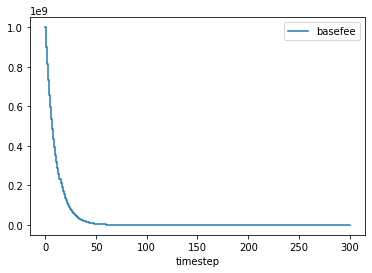

In [7]:
df.plot('timestep', ['basefee'])

Unsurprisingly, `basefee` decreases, in fact decreases quite fast to stabilise around just a few weis. We'll talk about the dynamics of basefee more when we dig into how the update is done.